In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as mlt
import seaborn as sp
from torch.autograd import Variable
from torch import autograd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [348]:
%run ../Pre_process/Data_preprocess.ipynb
%run Model/Mogrifier_LSTM.ipynb
%run train.ipynb
%run ../visualize.ipynb
%run test.ipynb
%run ../validation.ipynb

In [384]:
#df = pd.read_csv(processed_data_csv)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
#df1 = pd.read_csv(processed_data_csv)
# data1 = pd.read_csv("Data/Processed/acn_data_with_zero.csv")
# data2 = pd.read_csv("Data/Processed/palo_alto_data_with_zero.csv")
df = pd.read_csv("../Data/Processed/boulder_data_with_zero.csv")
# data3 = data1.loc[(data1['Start'] >= '2019-01-01 00:00:00') & (data1['Start'] <= '2019-12-31 23:00:00')]
# data2 = data2.loc[(data2['Start'] >= '2017-01-01 00:00:00') & (data2['Start'] <= '2018-01-01 23:00:00')]
# data1 = data3.loc[(data3['Start'] >= '2018-01-02 00:00:00') & (data3['Start'] <= '2018-12-31 23:00:00')]
# df = pd.concat([data2, data3, data1], axis=0).reset_index(drop=True)
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df.drop(columns=['Start'], inplace=True)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
input_size = df.shape[1]

In [385]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum', 'Hour'])
#df = pd.DataFrame(df, columns=['Energy'])

In [386]:
data_train, data_test, ground_truth_train, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [387]:
step_per_epoch = len(data_train) // batch_size

# Converting to tensor
data_train = torch.from_numpy(data_train).float().to(device)
ground_truth_train = torch.from_numpy(ground_truth_train).float().to(device)


# Seq2Seq Conv

Trainning------------------------------------------------------------------------------------------------------------------------------

In [388]:
hidden_size = 16
model = Mogrifier_LSTM(input_size, hidden_size, 1, batch_size).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)
loss_function_seq2seq = nn.MSELoss()

In [389]:
real_dataset, gen_dataset, errors_generator = train_mogrifier_lstm(model, optimizer, loss_function_seq2seq, data_train, ground_truth_train, step_per_epoch)

Epoch: 0 Loss G.: 25.162439346313477
Epoch: 1 Loss G.: 10.115307807922363
Epoch: 2 Loss G.: 7.282949447631836
Epoch: 3 Loss G.: 4.271961212158203
Epoch: 4 Loss G.: 1.2743521928787231
Epoch: 5 Loss G.: 0.8325924873352051
Epoch: 6 Loss G.: 0.6314066052436829
Epoch: 7 Loss G.: 0.690442681312561
Epoch: 8 Loss G.: 0.604542076587677
Epoch: 9 Loss G.: 0.8088980913162231
Epoch: 10 Loss G.: 0.5076496601104736
Epoch: 11 Loss G.: 0.5322006940841675
Epoch: 12 Loss G.: 0.3855839669704437
Epoch: 13 Loss G.: 0.41765546798706055
Epoch: 14 Loss G.: 0.6449896693229675
Epoch: 15 Loss G.: 0.7532322406768799
Epoch: 16 Loss G.: 1.316311001777649
Epoch: 17 Loss G.: 0.2816663086414337
Epoch: 18 Loss G.: 0.22444967925548553
Epoch: 19 Loss G.: 1.0141125917434692
Epoch: 20 Loss G.: 0.28754016757011414
Epoch: 21 Loss G.: 1.0788581371307373
Epoch: 22 Loss G.: 0.11793553829193115
Epoch: 23 Loss G.: 0.30827271938323975
Epoch: 24 Loss G.: 0.1945837438106537
Epoch: 25 Loss G.: 0.11386645585298538
Epoch: 26 Loss G.: 0.

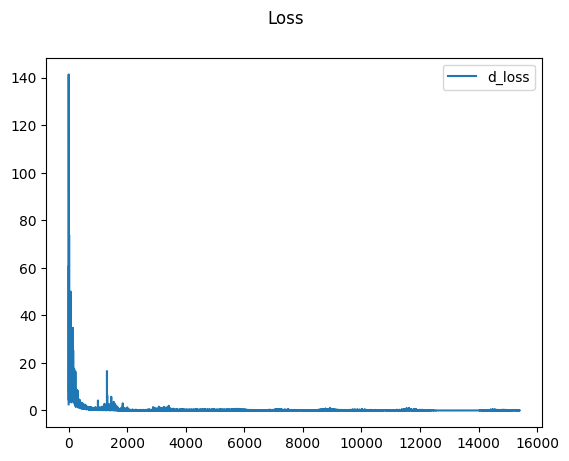

In [390]:
mlt.suptitle('Loss')
mlt.plot(errors_generator, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

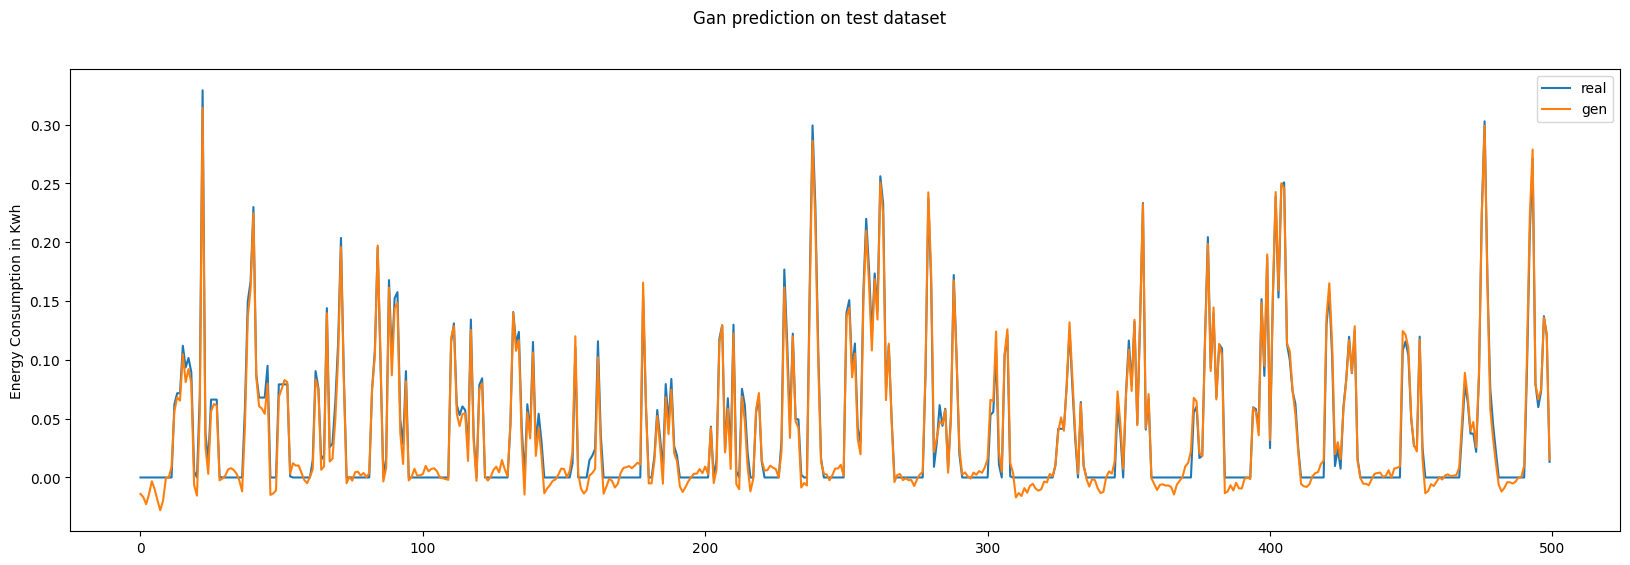

In [392]:
plot_full_dataset(real_dataset[:].detach().cpu().numpy(), gen_dataset[:].detach().cpu().numpy(), 500, 1000, 'Results/test1.png', 0)

Testing-------------------------------------------------------------------------------------------------------------------------------

In [393]:
df = pd.read_csv("../Data/Processed/boulder_data_with_zero.csv")
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df.drop(columns=['Start'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum', 'Hour'])

In [394]:

_, data_test, _, ground_truth_test = get_train_test_dataset_forecasting(df, train_ratio)

In [395]:
data_test = data_test[: -(data_test.shape[0] % batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % batch_size)]

In [396]:
step_per_epoch = len(data_test) // batch_size

In [397]:
# tr = df['Energy']
# mlt.figure(figsize=(20, 6))
# mlt.suptitle('Gan prediction on test dataset')
# mlt.ylabel('Energy Consumption in Kwh')
# mlt.plot(tr, label='real')
# mlt.legend()
# mlt.show()

In [398]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [399]:
real_data, predicted_data, loss = test_model(model, data_test, ground_truth_test, loss_function_seq2seq, step_per_epoch)

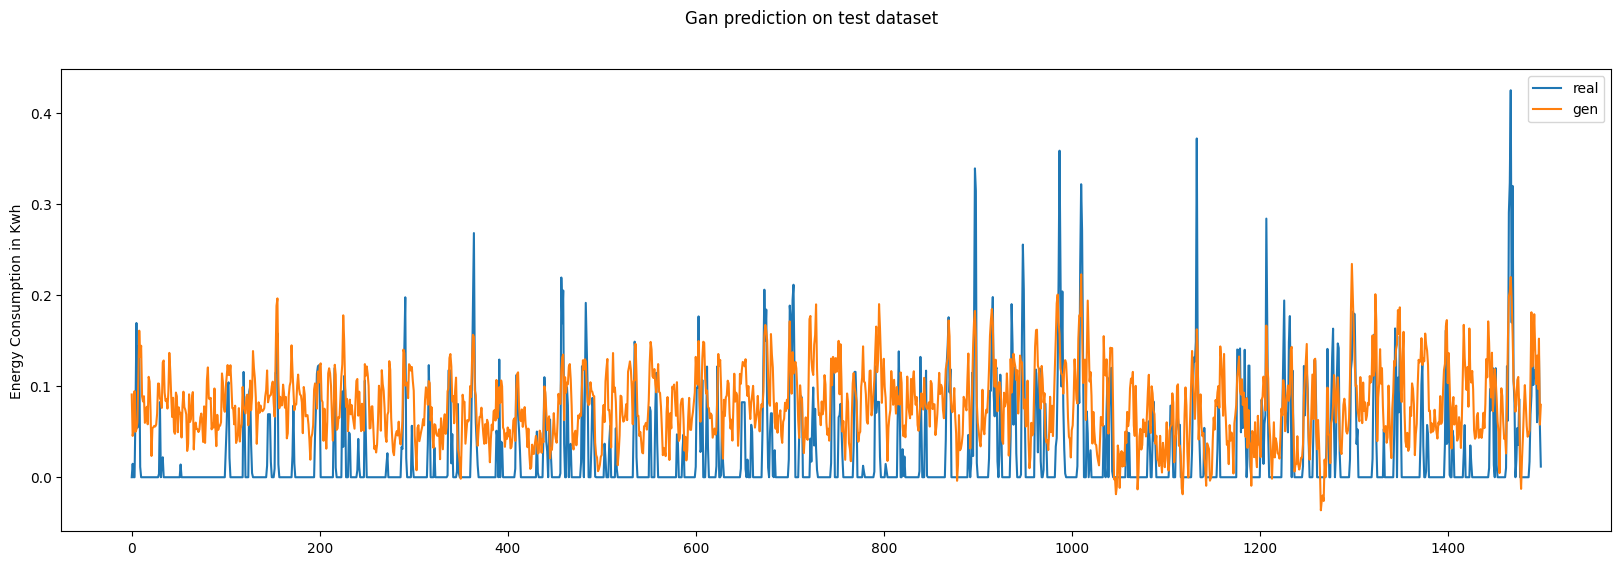

In [401]:
plot_full_dataset(real_data.detach().cpu().numpy(), predicted_data.detach().cpu().numpy(), 000, 1500, 'Results/test3.png', 0)

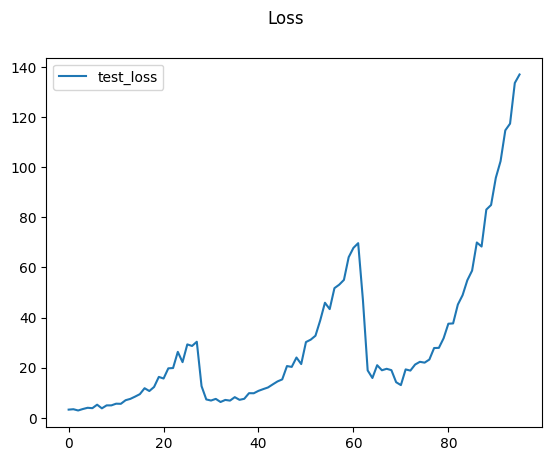

In [250]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

Evaluation----------------------------------------------------------------------------------------------------------------

In [251]:
validation_matrix(real_dataset_test_seq2seq.detach().cpu().numpy(), imputed_dataset.detach().cpu().numpy(), mask_test_result[:, -1, :].detach().cpu().numpy())

RMSE:10.159200668334961
MAE: 8.04447
MSE: 103.20935
R-squared: 0.9156770489960278
MAE: tensor(8.0445)
RMSE:10.159200668334961
R-squared: tensor(0.9157)
